# Оценка эффективности операторов колл-центров

## Цель проекта

`Чего мы хотим достичь` 
- определить можем ли мы разработать и предложить клиентам (колл-центрам) новый функционал сервиса по выявлению эффективности работы операторов.

`Для чего нам нужно достичь этих целей` 
- новый функционал может повысить конкурнтоспособность сервиса.

`Кто заинтересован в результате нашей работы` 
- Клиенты (колл-центры), которые получат инструмент регулирования мотивационной составляющей работы операторов. 
- Сервис получит лояльность действующих клиентов, перспективу увеличения клиентской базы, если этот функционал отсутствует у компаний-конкурентов, дополнительный доход.

`Какие решения будут предприняты на основании нашего анализа` 
- если на основании имеющихся данных, будут убедительно сформированы метрики будущего функционала, то ее реализация будет передана в разработку.

## Задача проекта

- На основании имеющихся данных определить рекомендуемые критерии оценки или систему оценки эффективности работы операторов
- Провести оценку эффективности операторов колл-центров по имеющимся данным

## Гипотезы по реализации проекта

Возможные метрики для определения эффективности работы оператора:

- По операторам колл-центров, специализирующимся на входящих звонках:
       - у оператора много пропущенных входящих вызовов, относительно общего количества обработанных звонков;
       - среднее время ожидания ответа оператора при входящих внешних вызовах значительно дольше среднего времени ожидания ответа всех операторов.

- По операторам колл-центров, специализирующимся на исходящих звонках:
       - мало исходящих вызовов относительно среднего количества исходящих вызовов всех операторов.

## Описание данных предоставленных заказчиком

Датасеты описывают использование услуг «Нупозвони» — провайдера виртуальный телефонии. Его клиенты — колл-центры, которые: 

- распределяют входящие вызовы на операторов,
- совершают исходящие вызовы силами операторов.

Также операторы могут делать внутренние вызовы —  вызовы друг между другом внутри сети виртуальной телефонии.

Колонки в `telecom_dataset.csv`:

- `user_id` — Идентификатор клиентского аккаунта в сервисе
- `date` — Дата статистики
- `direction` — Направление вызовов (out - исходящий вызов, in — входящий вызов)
- `internal` — Является ли звонок внутренним звонком между операторами клиента
- `operator_id` — Идентификатор оператора
- `is_missed_call` — Является ли звонок пропущенным
- `calls_count` — Количество звонков
- `call_duration` — Длительность звонка (без учета времени ожидания)
- `total_call_duration` — Длительность звонка (с учетом времени ожидания)

Колонки в `telecom_clients.csv`:

- `user_id` — Идентификатор клиентского аккаунта в сервисе
- `tariff_plan` — Текущий тарифный план клиента
- `date_start` — Дата регистрации клиентв в сервисе

## Предобработка данных

### Библиотеки необходимые для работы с проектом

In [986]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from scipy import stats as st
import numpy as np
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.float_format', '{:,.2f}'.format)

### Просмотр датасетов

In [987]:
# Функция для просмотра датасетов
def view(data):
    return (
           display(data.head(10)),
           display(data.info()),
           display(data.describe()),
           data.isna().mean(),
           print(f'В датасете {len(data) - len(data.drop_duplicates())} дубликатов')           
    )

In [988]:
telecom_clients = pd.read_csv('https://code.s3.yandex.net/datasets/telecom_clients.csv')

In [989]:
telecom_dataset = pd.read_csv('https://code.s3.yandex.net/datasets/telecom_dataset.csv')

#### Сведения о клиентах

In [990]:
view(telecom_clients)

,user_id,tariff_plan,date_start
0,166713,A,2019-08-15
1,166901,A,2019-08-23
2,168527,A,2019-10-29
3,167097,A,2019-09-01
4,168193,A,2019-10-16
5,167764,A,2019-09-30
6,167050,A,2019-08-29
7,168252,A,2019-10-17
8,168495,A,2019-10-28
9,167879,A,2019-10-03


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      732 non-null    int64 
 1   tariff_plan  732 non-null    object
 2   date_start   732 non-null    object
dtypes: int64(1), object(2)
memory usage: 17.3+ KB


None

,user_id
count,732.00
mean,"167,431.93"
std,633.81
min,"166,373.00"
25%,"166,900.75"
50%,"167,432.00"
75%,"167,973.00"
max,"168,606.00"


В датасете 0 дубликатов


(None,
 None,
 None,
 user_id       0.00
 tariff_plan   0.00
 date_start    0.00
 dtype: float64,
 None)

**Выводы** В датасете отсутствуют явные дубликаты и пропущенные значения

#### Данные о работе колл-центров

In [991]:
view(telecom_dataset)

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
1,166377,2019-08-05 00:00:00+03:00,out,True,"880,022.00",True,3,0,5
2,166377,2019-08-05 00:00:00+03:00,out,True,"880,020.00",True,1,0,1
3,166377,2019-08-05 00:00:00+03:00,out,True,"880,020.00",False,1,10,18
4,166377,2019-08-05 00:00:00+03:00,out,False,"880,022.00",True,3,0,25
5,166377,2019-08-05 00:00:00+03:00,out,False,"880,020.00",False,2,3,29
6,166377,2019-08-05 00:00:00+03:00,out,False,"880,020.00",True,8,0,50
7,166377,2019-08-05 00:00:00+03:00,in,False,NaN,True,6,0,35
8,166377,2019-08-05 00:00:00+03:00,out,False,"880,020.00",True,8,0,50
9,166377,2019-08-06 00:00:00+03:00,in,False,NaN,True,4,0,62


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53902 non-null  int64  
 1   date                 53902 non-null  object 
 2   direction            53902 non-null  object 
 3   internal             53785 non-null  object 
 4   operator_id          45730 non-null  float64
 5   is_missed_call       53902 non-null  bool   
 6   calls_count          53902 non-null  int64  
 7   call_duration        53902 non-null  int64  
 8   total_call_duration  53902 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB


None

,user_id,operator_id,calls_count,call_duration,total_call_duration
count,"53,902.00","45,730.00","53,902.00","53,902.00","53,902.00"
mean,"167,295.34","916,535.99",16.45,866.68,"1,157.13"
std,598.88,"21,254.12",62.92,"3,731.79","4,403.47"
min,"166,377.00","879,896.00",1.00,0.00,0.00
25%,"166,782.00","900,788.00",1.00,0.00,47.00
50%,"167,162.00","913,938.00",4.00,38.00,210.00
75%,"167,819.00","937,708.00",12.00,572.00,902.00
max,"168,606.00","973,286.00","4,817.00","144,395.00","166,155.00"


В датасете 4900 дубликатов


(None,
 None,
 None,
 user_id               0.00
 date                  0.00
 direction             0.00
 internal              0.00
 operator_id           0.15
 is_missed_call        0.00
 calls_count           0.00
 call_duration         0.00
 total_call_duration   0.00
 dtype: float64,
 None)

**Вывод**
- Данные содержат 4900 явных дубликатов
- В колонке `operator_id` содержится 15% пропусков, также небольшое количество пропусков (117, менее 1%) содержится в столбце `internal`
- Данные в столбце `date` нужно привести к типу `datetime`
- Данные в столбце `operator_id` нужно привести к типу `int`
- изучение информации по столбцам `call_duration` и `total_call_duration`, а также столбца `calls_count` более вероятно предположить, что в датасете продолжительности звонков приведены в секундах.

### Работа с дубликатами в данных

Дубликаты составляют 9% имеющихся данных. Для целей проекта, самым оптимальным будет их удалить, но предварительно можно провести дополнительный анализ, по каким колл-центрам распределены дубликаты, для дальнейшей работы по снижению количества дубликатов в данных. Также, можно предположить, что удаление дубликатов положительно скажется на снижение количества строк с пропусками в данных.

#### Данные по дубликатам строк в информации по колл-центрам

In [992]:
# Получим сведения о доле дубликатов в выгрузке данных в разбивке по колл-центрам
data_duplicate = (telecom_dataset[
                 telecom_dataset[[
                                  'user_id', 
                                  'date', 
                                  'direction', 
                                  'internal', 
                                  'operator_id', 
                                  'is_missed_call', 
                                  'calls_count', 
                                  'call_duration', 
                                  'total_call_duration'
                                ]]
                                  .duplicated() == True]
                                  .groupby(by='user_id')
                                  .count()
                                  .reset_index()
                                  .sort_values('date', ascending=False)
                                  .reset_index(drop=True)
                                  .drop(columns=[
                                  'direction', 
                                  'internal', 
                                  'operator_id', 
                                  'is_missed_call', 
                                  'calls_count', 
                                  'call_duration', 
                                  'total_call_duration'   
                                  ])
                                  .rename(columns={'date': 'duplicate_count'})
)

In [993]:
# Получим сведения о количестве данных по каждому колл-центру
row_count = (telecom_dataset.groupby(by='user_id')
                .count()
                .reset_index()
                .sort_values('date', ascending=False)
                .reset_index(drop=True)
                .drop(columns=[
                                  'direction', 
                                  'internal', 
                                  'operator_id', 
                                  'is_missed_call', 
                                  'calls_count', 
                                  'call_duration', 
                                  'total_call_duration'   
                                  ])
                .rename(columns={'date': 'row_count'})
)

In [994]:
share_duplicate = row_count.merge(data_duplicate, how = 'left', left_on='user_id', right_on='user_id').fillna(0).astype('int')
share_duplicate['share'] = share_duplicate['duplicate_count']/share_duplicate['row_count']
share_duplicate.sort_values(by='row_count', ascending=False).reset_index(drop=False).head(10)

,index,user_id,row_count,duplicate_count,share
0,0,168187,2580,238,0.09
1,1,166658,2107,223,0.11
2,2,167497,1405,124,0.09
3,3,167626,1311,131,0.10
4,4,166916,1308,104,0.08
5,5,168361,1262,113,0.09
6,6,168062,1182,101,0.09
7,7,167150,1156,93,0.08
8,8,166405,1042,80,0.08
9,9,166983,1038,89,0.09


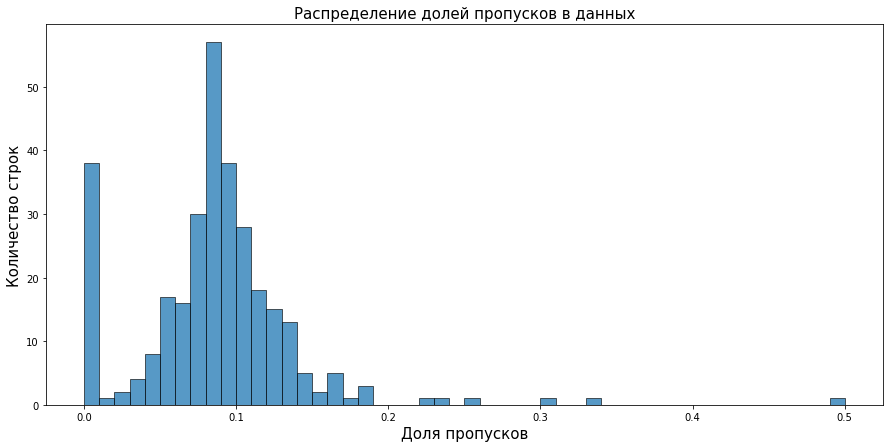

In [995]:
fig, axes = plt.subplots()
ax = sns.histplot(share_duplicate['share'], bins=50)
ax.set_xlabel('Доля пропусков', fontsize = '15')
ax.set_ylabel('Количество строк', fontsize = '15')
ax.set_title('Распределение долей пропусков в данных', fontsize = '15')    
fig.set_figwidth(15)    
fig.set_figheight(7)  

**Промежуточные выводы** В данном разделе подготовлена сводная таблица с распределением дубликатов в сведениях по колл-центрам, а также визуализировано распределение этиих значений. Практически по 60 колл-центрам число пропусков составляет около 10%

#### Удаление дубликатов

In [996]:
telecom_dataset = telecom_dataset.drop_duplicates().reset_index(drop=True)
telecom_dataset

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
1,166377,2019-08-05 00:00:00+03:00,out,True,"880,022.00",True,3,0,5
2,166377,2019-08-05 00:00:00+03:00,out,True,"880,020.00",True,1,0,1
3,166377,2019-08-05 00:00:00+03:00,out,True,"880,020.00",False,1,10,18
4,166377,2019-08-05 00:00:00+03:00,out,False,"880,022.00",True,3,0,25
...,...,...,...,...,...,...,...,...,...
48997,168606,2019-11-10 00:00:00+03:00,out,True,"957,922.00",False,1,0,25
48998,168606,2019-11-10 00:00:00+03:00,out,True,"957,922.00",True,1,0,38
48999,168606,2019-11-11 00:00:00+03:00,out,True,"957,922.00",False,2,479,501
49000,168606,2019-11-15 00:00:00+03:00,out,True,"957,922.00",False,4,3130,3190


In [997]:
telecom_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49002 entries, 0 to 49001
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              49002 non-null  int64  
 1   date                 49002 non-null  object 
 2   direction            49002 non-null  object 
 3   internal             48892 non-null  object 
 4   operator_id          41546 non-null  float64
 5   is_missed_call       49002 non-null  bool   
 6   calls_count          49002 non-null  int64  
 7   call_duration        49002 non-null  int64  
 8   total_call_duration  49002 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.0+ MB


In [998]:
telecom_dataset.isna().mean()

user_id               0.00
date                  0.00
direction             0.00
internal              0.00
operator_id           0.15
is_missed_call        0.00
calls_count           0.00
call_duration         0.00
total_call_duration   0.00
dtype: float64

**Выводы** После удаления дубликатов, число пропусков в столбцах `internal` и `operator_id`незначительно снизилось, но доли этих пропусков остались на прежнем уровне.

### Провести работу с пропусками в данных

#### Пропуски в столбце `operator_id`

Для того, чтобы предположить причины появления пропусков в столбце `operator_id`, посмотрим какие значения в других столбцах таких данных.

In [999]:
# Сделаем небольшой сэмпл данных, который покажет, какие аггрегированные значения имеют другие столбцы в строках с пропусками
y=telecom_dataset[telecom_dataset['operator_id'].isna()]
x=list(telecom_dataset.columns)
for i in x:
    print(y[i].value_counts().head())

168252    135
166582    111
166405    111
166782    106
166658    103
Name: user_id, dtype: int64
2019-10-28 00:00:00+03:00    128
2019-11-28 00:00:00+03:00    127
2019-11-12 00:00:00+03:00    125
2019-11-07 00:00:00+03:00    123
2019-11-26 00:00:00+03:00    123
Name: date, dtype: int64
in     7270
out     186
Name: direction, dtype: int64
False    7078
True      323
Name: internal, dtype: int64
Series([], Name: operator_id, dtype: int64)
True     7343
False     113
Name: is_missed_call, dtype: int64
1    2571
2    1234
3     736
4     471
5     297
Name: calls_count, dtype: int64
0      7343
49        2
53        2
229       2
145       2
Name: call_duration, dtype: int64
2    543
0    332
4    254
1    239
6    175
Name: total_call_duration, dtype: int64


**Промежуточные выводы** Практически все пропуски в столбце `operator_id` можно объяснить тем, что данные звонки относятся к входящим внешним пропущенным звонкам, то есть это в основном те звонки, когда абонент не дождался ответа оператора. Наиболее оптимальным для дальнейшей реализации проекта будет заполнить пропуски значеним `0`, это позволит не потерять какие то важные для других разделов проекта данные и одновременно маркировать значение в столбце `operator_id`

#### Пропуски в столбце `internal`

In [1000]:
y=telecom_dataset[telecom_dataset['internal'].isna()]
x=list(telecom_dataset.columns)
for i in x:
    print(y[i].value_counts().head())

167626    13
167650    13
167110     9
168361     5
167852     5
Name: user_id, dtype: int64
2019-10-23 00:00:00+03:00    6
2019-10-01 00:00:00+03:00    5
2019-11-14 00:00:00+03:00    4
2019-10-09 00:00:00+03:00    4
2019-10-31 00:00:00+03:00    3
Name: date, dtype: int64
in     108
out      2
Name: direction, dtype: int64
Series([], Name: internal, dtype: int64)
921,318.00    4
932,798.00    3
919,552.00    2
901,880.00    2
890,404.00    2
Name: operator_id, dtype: int64
True     56
False    54
Name: is_missed_call, dtype: int64
1    83
2    14
3     6
6     2
5     1
Name: calls_count, dtype: int64
0     55
5      2
81     2
11     2
15     2
Name: call_duration, dtype: int64
4     8
2     5
0     4
9     4
15    4
Name: total_call_duration, dtype: int64


**Промежуточные выводы** По полученному сэмплу сложно сказать о причинах появления данных пропусков в данных, но учитывая незначительное количество пропусков, думаю самым разумным будет заполнить пропуски значанием `False`, потому что обоснованно предположить по каким критериям можно отнести эти звонки в к внутренним или внешним не представляется возможным, но соотношение значений False и True говорит о том, что подавляющее число значений в этом сталбце являются `False`.

#### Заполнение пропусков и корректировка типов данных

Самым оптимальным типом данных в столбце `operator_id` для дальнейшего проекта будет тип `int`

In [1001]:
telecom_dataset['operator_id'] = telecom_dataset['operator_id'].fillna(0).astype('int64')
telecom_dataset.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,0,True,2,0,4
1,166377,2019-08-05 00:00:00+03:00,out,True,880022,True,3,0,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020,True,1,0,1
3,166377,2019-08-05 00:00:00+03:00,out,True,880020,False,1,10,18
4,166377,2019-08-05 00:00:00+03:00,out,False,880022,True,3,0,25


In [1002]:
telecom_dataset['internal'] = telecom_dataset['internal'].fillna(False)

In [1003]:
telecom_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49002 entries, 0 to 49001
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   user_id              49002 non-null  int64 
 1   date                 49002 non-null  object
 2   direction            49002 non-null  object
 3   internal             49002 non-null  bool  
 4   operator_id          49002 non-null  int64 
 5   is_missed_call       49002 non-null  bool  
 6   calls_count          49002 non-null  int64 
 7   call_duration        49002 non-null  int64 
 8   total_call_duration  49002 non-null  int64 
dtypes: bool(2), int64(5), object(2)
memory usage: 2.7+ MB


**Вывод** мы заполнили пропуски данных и можем переходить к исследовательскому анализу данных.

#### Дополнительный отчет о пропусках в разбивке по колл-центрам

Наличие такого значительного количества пропусков дает повод подготовить информацию, в каких колл-центрах эта проблема является наиболее существенной. Для этого необходимо получить сведения о количестве звонков по всем коллцентрам, а также о количестве звонков, где оператор не был определен. 

In [1004]:
# Получим общее количество строк, где оператор не был идентифицирован
len(telecom_dataset.query("operator_id == 0"))

7456

In [1005]:
# Сделаем сводную таблицу об общем количестве звонков в разбивке по колл-центрам
operator_full = (telecom_dataset
                                .pivot_table(index='user_id', values='calls_count', aggfunc='sum')
                                .reset_index()
                                .sort_values(by='calls_count', ascending=False)
                                .reset_index(drop=True)
                )

In [1006]:
# Получим данные о количестве звонков, когда оператор не был идетифицирован в разбивке по колл-центрам
operator_zero = (telecom_dataset.query("operator_id == 0")
                                .pivot_table(index='user_id', values='calls_count', aggfunc='sum')
                                .reset_index()
                                .sort_values(by='calls_count', ascending=False)
                                .reset_index(drop=True)
                )

In [1007]:
# Объединим две полученные таблицы и долю, которую составляют данные без сведений об операторах
operator_brock = operator_full.merge(operator_zero, how = 'left', left_on='user_id', right_on='user_id').fillna(0).astype('int')
operator_brock.columns = ['user_id', 'calls_all', 'calls_operator_zero']
operator_brock['share'] = operator_brock['calls_operator_zero']/operator_brock['calls_all']
operator_brock.sort_values(by='share', ascending=False).reset_index(drop=True).head()

,user_id,calls_all,calls_operator_zero,share
0,167981,1,1,1.00
1,166554,2,2,1.00
2,167114,5,5,1.00
3,168446,5,5,1.00
4,168329,9,9,1.00


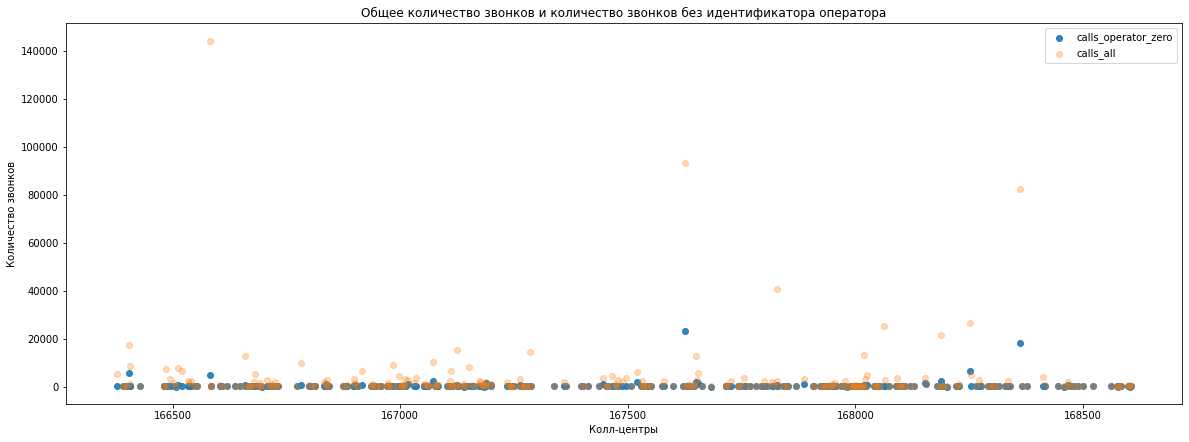

In [1008]:
# Визуализация
fig, ax = plt.subplots()
ax.scatter(operator_brock['user_id'], operator_brock['calls_operator_zero'], label='calls_operator_zero', alpha=0.9)
ax.scatter(operator_brock['user_id'], operator_brock['calls_all'], label='calls_all', alpha=0.3)

ax.set_xlabel('Колл-центры')
ax.set_ylabel('Количество звонков')
ax.set_title('Общее количество звонков и количество звонков без идентификатора оператора')
ax.legend()
fig.set_figwidth(20)    
fig.set_figheight(7)  

plt.show()

**Вывод** На данной визуализации видно, что некоторые колл-центры имеют большое количество пропущенных входящих звонков, что может говорить о том, что в данных колл-центрах недостаточно операторов, для обработки всех входящих звонков и абоненты просто не дожидаются ответа оператора.

### Оценить необходимость дополнения исходного датасета дополнительными параметрами

Для дальнейшего проведения проекта, поскольку наши данные носят аггрегированных характер по дню сбора сведений, считаю необходимым добавить дополнительные столбцы в исходный датасет:
- данные о среднем времени ожидания ответа оператора `avg_expectation`
- данные о средней продолжительности одного звонка `avg_call_duration`

In [1009]:
telecom_dataset['avg_expectation'] = ((telecom_dataset['total_call_duration'] - telecom_dataset['call_duration'])/telecom_dataset['calls_count']).astype('int64')
telecom_dataset['avg_call_duration'] = (telecom_dataset['call_duration']/telecom_dataset['calls_count']).astype('int64') 

In [1010]:
telecom_dataset.describe(percentiles=[.9, .95, .99])

,user_id,operator_id,calls_count,call_duration,total_call_duration,avg_expectation,avg_call_duration
count,"49,002.00","49,002.00","49,002.00","49,002.00","49,002.00","49,002.00","49,002.00"
mean,"167,294.89","777,067.83",16.46,866.28,"1,156.56",16.54,66.37
std,598.56,"329,773.74",63.60,"3,775.50","4,451.47",13.87,125.16
min,"166,377.00",0.00,1.00,0.00,0.00,0.00,0.00
50%,"167,158.00","906,406.00",4.00,37.00,208.00,14.00,23.00
90%,"168,187.00","944,764.00",35.00,"2,092.00","2,610.80",32.00,168.00
95%,"168,271.00","948,758.00",62.00,"3,725.95","4,531.00",40.00,253.95
99%,"168,412.00","961,770.00",165.00,"10,314.91","12,956.00",60.00,580.00
max,"168,606.00","973,286.00","4,817.00","144,395.00","166,155.00",465.00,"3,550.00"


**Выводы** Исходный датасет дополнен сведениями о среднем времени ожидания ответа оператора и средней продолжительности одного звонка, эти значения сразу приведены к типу `int`

### Провести работу с типами данных

В рамках предобработки данных ранее мной приведены практически все столбцы к нужным типам. Осталось привести столбец `user_id` к типу `category`, а также столбец `date` к типу `datetime`

In [1011]:
telecom_dataset['user_id'] = telecom_dataset['user_id'].astype('category')

In [1012]:
telecom_dataset['date'] = pd.to_datetime(telecom_dataset['date'], format='%Y-%m-%d')
telecom_dataset['date'] = telecom_dataset['date'].dt.date
telecom_dataset['date'] = telecom_dataset['date'].astype('datetime64[ns]')
print(f"Нам предоставлены данные за период с {telecom_dataset['date'].min()} по {telecom_dataset['date'].max()}")

Нам предоставлены данные за период с 2019-08-02 00:00:00 по 2019-11-28 00:00:00


In [1013]:
telecom_dataset.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,avg_expectation,avg_call_duration
0,166377,2019-08-04,in,False,0,True,2,0,4,2,0
1,166377,2019-08-05,out,True,880022,True,3,0,5,1,0
2,166377,2019-08-05,out,True,880020,True,1,0,1,1,0
3,166377,2019-08-05,out,True,880020,False,1,10,18,8,10
4,166377,2019-08-05,out,False,880022,True,3,0,25,8,0


**Общие выводы по разделу** В рамках предобработки данных осуществлено:
- Загружены и узучены данные
- проведена работа с дубликатами, получены сведения в каких колл-центрах дубликаты составляют значительное количество, для дальнейшей реализации проекта дубликаты удалены
- Проведена работа с пропусками данных, получены сведения, по каким колл-центрам распределены данные пропуски.
- Исходный датасет дополнен сведения о среднем времени ожидания ответа оператора и средней продолжительности одного звонка
- все значения приведены к нужным нам типам данным

## Исследовательский анализ данных

Рассмотрение системы определения эффективности операторов колл-центров предлагается по следующей логике.
На первом этапе необходимо разобраться со специализацией колл-центров, какие колл-центры специализируются на входящих звонках, какие на исходящих, а какие колл-центры являются гибридными и оказывают как услуги по обработке входящих сообщений, так и услуги по обзвону. Аналогичную работу необходимо провести в отноешнии операторов.

### Категоризация колл-центров и операторов на предмет специализации по входящим или исходящим звонкам

#### Категоризация колл-центров по исходящим/входящим вызовам

##### Свод информации по колл-центрам

In [1014]:
# Для получения сводных данных исключим возмем только те данные, где звонки отмечены, как внешние
user_in_out = (telecom_dataset.query('internal != True & internal != "unknown"')
                             .pivot_table(index=['user_id', 'direction'], values='calls_count', aggfunc='sum')
                             .unstack()
                             .reset_index())

In [1015]:
# скорректируем названия столбцов
user_in_out.columns = ['user_id', 'in', 'out']

In [1016]:
# добавим столбец с общим количеством звонков
user_in_out['calls_sum'] = user_in_out['in']+user_in_out['out']

In [1017]:
# получим сведения о том какую долю составляют входящие звонки
user_in_out['in_share'] = user_in_out['in']/user_in_out['calls_sum']

In [1018]:
# получим сведения о том какую долю составляют исходящие звонки
user_in_out['out_share'] = user_in_out['out']/user_in_out['calls_sum']

In [1019]:
# посмотрим, что у нас получилось
user_in_out.sort_values(['calls_sum'], ascending=False).reset_index(drop=True).head(10)

,user_id,in,out,calls_sum,in_share,out_share
0,166582,7471,137026,144497,0.05,0.95
1,167626,27115,66278,93393,0.29,0.71
2,168361,17981,64669,82650,0.22,0.78
3,167827,1766,38906,40672,0.04,0.96
4,168252,13901,12301,26202,0.53,0.47
5,168062,637,24072,24709,0.03,0.97
6,168187,7496,13333,20829,0.36,0.64
7,166405,7711,9789,17500,0.44,0.56
8,167125,672,14489,15161,0.04,0.96
9,167285,92,14252,14344,0.01,0.99


**Выводы** Мы получили сводную таблицу по колл-центрам со сведениями о количествах и долях входящих и исходящих звонков

##### Категоризация колл-центров

Категоризация будет проводиться по следующим принципам и исходя из определенных предпосылок:
- нам предоставлены данные за несколько месяцев, поэтому однозначно утверждать, что количество звонков в данном периоде показательно для конкретного колл-центра мы не можем в связи с возможным фактором сезонности.
- учитывая вышесказанное предлагается исходить из того, что если доля каких то звонков равняется или превышает 75% от общего числа звонков, то это может говорит о том, что данный колл-центр специализируется на таких звонках.
- Если этот показатель ниже 75% то, такие колл-центры предлагается в рамках данного проекта считать гибридными.

In [1020]:
# напишем функцию категоризации, которая пригодится нам и для категоризации колл-центров и для категоризации операторов
def categorize(in_share):
    if in_share >= 0.75:
        return 'in'
    if in_share < 0.25:
        return 'out'
    return 'hybrid'

In [1021]:
# добавим сведения о категории колл-центра
user_in_out['user_category'] = user_in_out.in_share.map(categorize)
user_in_out.head()

,user_id,in,out,calls_sum,in_share,out_share,user_category
0,166377,196,4898,5094,0.04,0.96,out
1,166391,15,0,15,1.00,0.00,in
2,166392,208,0,208,1.00,0.00,in
3,166399,24,0,24,1.00,0.00,in
4,166405,7711,9789,17500,0.44,0.56,hybrid


##### Визуализация полученных данных

In [1022]:
user_in_out.pivot_table(values = 'user_id', index = 'user_category', aggfunc='count').reset_index()

,user_category,user_id
0,hybrid,99
1,in,136
2,out,72


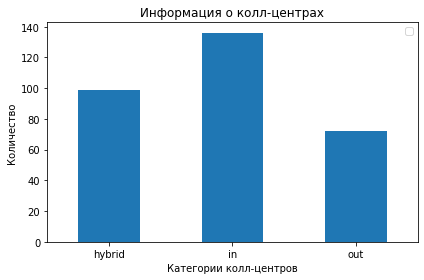

In [1023]:
# Для презентации подготовим несколько визуализаций
# Барчарт
user_in_out.pivot_table(values = 'user_id', index = 'user_category', aggfunc='count').plot(kind='bar')
plt.xticks(rotation=0, horizontalalignment="center")
plt.title("Информация о колл-центрах")
plt.xlabel("Категории колл-центров")
plt.ylabel("Количество")
plt.legend('')
plt.tight_layout()
plt.show()

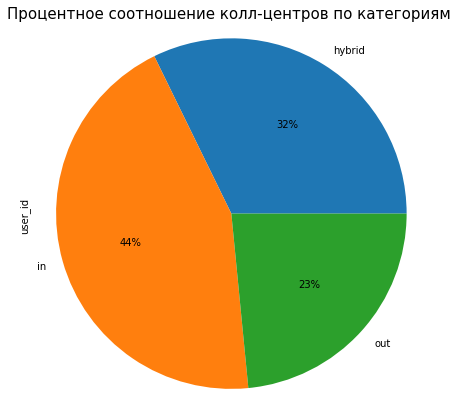

In [1024]:
# Круговую диаграмму
fig, ax = plt.subplots()
user_in_out.groupby(by='user_category').count()['user_id'].plot(kind='pie', autopct='%1.f%%')
ax.axis('equal')  
fig.set_size_inches(7,7)
ax.set_title('Процентное соотношение колл-центров по категориям', fontsize = '15')
plt.show()

**Выводы** с учетом примененных предпосылок и принципов было установлено, что 44% процента колл-центров можно отнести к специализирующимся на входящих звонках, 23% специализируются на исходящих звонках и 32% можно отнести к гибридным колл-центрам

#### Категоризация операторов по исходящим/входящим вызовам

По аналогичному алгоритму получим сведения о категориях операторов

##### Свод по операторам

In [1025]:
# Для получения сводных данных исключим возмем только те данные, где звонки отмечены, как внешние
operator_in_out = (telecom_dataset.query('internal != True & internal != "unknown"')
                             .pivot_table(index=['operator_id', 'direction'], values='calls_count', aggfunc='sum')
                             .unstack()
                             .reset_index()
                             .fillna(0))

In [1026]:
# скорректируем названия столбцов
operator_in_out.columns = ['operator_id', 'in', 'out']

In [1027]:
# добавим столбец с общим количеством звонков
operator_in_out['calls_sum'] = operator_in_out['in']+operator_in_out['out']

In [1028]:
# получим сведения о том какую долю составляют входящие звонки
operator_in_out['in_share'] = operator_in_out['in']/operator_in_out['calls_sum']

In [1029]:
# получим сведения о том какую долю составляют исходящие звонки
operator_in_out['out_share'] = operator_in_out['out']/operator_in_out['calls_sum']

In [1030]:
# посмотрим, что у нас получилось
operator_in_out.sort_values(['calls_sum'], ascending=False).reset_index(drop=True).head()

,operator_id,in,out,calls_sum,in_share,out_share
0,0,"103,113.00",461.00,"103,574.00",1.00,0.00
1,885890,"1,244.00","58,977.00","60,221.00",0.02,0.98
2,885876,992.00,"58,434.00","59,426.00",0.02,0.98
3,929428,0.00,"23,754.00","23,754.00",0.00,1.00
4,925922,418.00,"19,603.00","20,021.00",0.02,0.98


##### Категоризация операторов по соотношению исходящих/входящих вызовов

In [1031]:
# добавим сведения о категории колл-центра
operator_in_out['operator_category'] = operator_in_out.in_share.map(categorize)
operator_in_out = operator_in_out.drop([0]).reset_index(drop=True)
operator_in_out.head()

,operator_id,in,out,calls_sum,in_share,out_share,operator_category
0,879896,58.00,816.00,874.00,0.07,0.93,out
1,879898,104.00,"7,191.00","7,295.00",0.01,0.99,out
2,880020,7.00,34.00,41.00,0.17,0.83,out
3,880022,8.00,174.00,182.00,0.04,0.96,out
4,880026,24.00,"2,188.00","2,212.00",0.01,0.99,out


##### Визуализация полученных данных

In [1032]:
operator_in_out .pivot_table(values = 'operator_id', index = 'operator_category', aggfunc='count').reset_index()

,operator_category,operator_id
0,hybrid,219
1,in,303
2,out,533


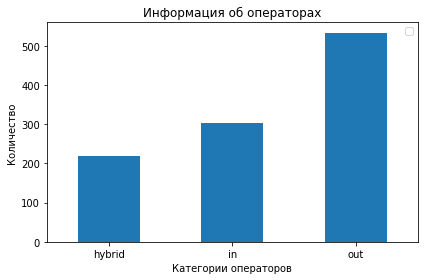

In [1033]:
# Для презентации подготовим несколько визуализаций
# Барчарт
operator_in_out.pivot_table(values = 'operator_id', index = 'operator_category', aggfunc='count').plot(kind='bar')
plt.xticks(rotation=0, horizontalalignment="center")
plt.title("Информация об операторах")
plt.xlabel("Категории операторов")
plt.ylabel("Количество")
plt.legend('')
plt.tight_layout()
plt.show()

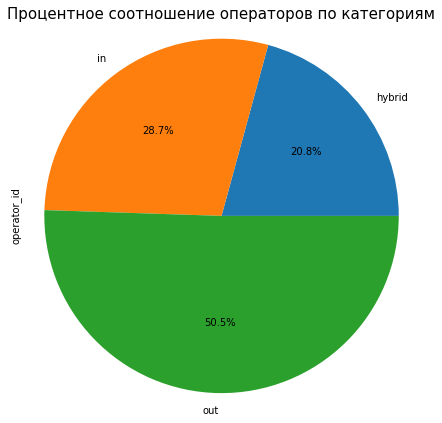

In [1034]:
# Круговая диаграмма
fig, ax = plt.subplots()
operator_in_out.groupby(by='operator_category').count()['operator_id'].plot(kind='pie', autopct='%1.1f%%')
ax.axis('equal')  
fig.set_size_inches(7,7)
ax.set_title('Процентное соотношение операторов по категориям', fontsize = '15')
plt.show()

**Выводы** Ситуация по операторам несколько иная, 51% операторов специализировались на исходящих звонках, 29% на входящих и 21% работали с обоими типами звонков

#### Включение в исходный датасет информации о категориях колл-центров и операторов

In [1035]:
telecom_dataset = telecom_dataset.merge(user_in_out[['user_id', 'user_category']], how = 'left', on='user_id')

In [1036]:
telecom_dataset = telecom_dataset.merge(operator_in_out[['operator_id', 'operator_category']], how = 'left', on='operator_id')

In [1037]:
# данные, где отсутствует идентификатор оператора присвоим категорию 0
telecom_dataset['operator_category'] = telecom_dataset['operator_category'].fillna(0)

In [1038]:
telecom_dataset.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,avg_expectation,avg_call_duration,user_category,operator_category
0,166377,2019-08-04,in,False,0,True,2,0,4,2,0,out,0
1,166377,2019-08-05,out,True,880022,True,3,0,5,1,0,out,out
2,166377,2019-08-05,out,True,880020,True,1,0,1,1,0,out,out
3,166377,2019-08-05,out,True,880020,False,1,10,18,8,10,out,out
4,166377,2019-08-05,out,False,880022,True,3,0,25,8,0,out,out


### Соотношение входящих принятых и пропущенных операторами звонков 

В качестве первой метрики предлагается рассмотреть соотношение принятых и пропущенных операторами входящих звонков, при этом будут рассмотрены все входящие звонки, как внешние так и внутренние, поскольку это позволит оперировать в том числе входящими звонками переведенными от одного оператора другому. Суть метрики заключается в том, что людям, которые звонят в колл-центры важно, чтобы их звонок был обработан, соответственно небольшое количество пропущенных звонков относительно обработанных может служить показателем хорошей работы оператора.

#### Сводная таблица по каждому оператору с данными о принятых и пропущенных входящих звонках

In [1039]:
# сделаем сводную таблицу по каждому оператору с количеством принятых (`accept`) и пропущенных (`missed`) звонков, 
#а также общее количество звонков и долю принятых звонков от общего количества
operator_in_ef = telecom_dataset.query('operator_id != 0 & direction == "in"').pivot_table(index=['operator_id', 'is_missed_call'], values='calls_count', aggfunc='sum').unstack().reset_index()
operator_in_ef.columns = ['operator_id', 'accept', 'missed']
operator_in_ef['missed'] = operator_in_ef['missed'].fillna(0)
operator_in_ef['accept'] = operator_in_ef['accept'].fillna(0)
operator_in_ef['accept'] = operator_in_ef['accept'].astype('int64')
operator_in_ef['missed'] = operator_in_ef['missed'].astype('int64')
operator_in_ef['calls_all'] = operator_in_ef['accept'] + operator_in_ef['missed']
operator_in_ef['share_accept'] = operator_in_ef['accept']/operator_in_ef['calls_all']
operator_in_ef = operator_in_ef.sort_values(['accept'], ascending=False).reset_index(drop=True)
operator_in_ef.head()

,operator_id,accept,missed,calls_all,share_accept
0,913938,4752,14,4766,1.00
1,952948,3534,8,3542,1.00
2,893804,2423,10,2433,1.00
3,913942,2415,52,2467,0.98
4,921318,2317,6,2323,1.00


In [1040]:
# поскольку в исследуемом периоде операторы работали разное количество дней, получим сведения 
# о количестве рабочих дней, для каждого оператора 
operator_days = (telecom_dataset.query('operator_id != 0')
                               .pivot_table(index='operator_id', values='date', aggfunc='nunique')
                               .reset_index())
operator_days.head()

,operator_id,date
0,879896,50
1,879898,84
2,880020,14
3,880022,42
4,880026,77


In [1041]:
# соединим информацию из 2 таблиц
operator_in_ef = operator_in_ef.merge(operator_days[['operator_id', 'date']], how = 'left', on='operator_id')
operator_in_ef['calls_day'] = operator_in_ef['calls_all']/operator_in_ef['date'] # добавим среднее количество звонков в день
operator_in_ef['missed_day'] = operator_in_ef['missed']/operator_in_ef['date'] # добавим среднее количество пропущенных звонков в рабочий день
operator_in_ef.head()

,operator_id,accept,missed,calls_all,share_accept,date,calls_day,missed_day
0,913938,4752,14,4766,1.00,65,73.32,0.22
1,952948,3534,8,3542,1.00,26,136.23,0.31
2,893804,2423,10,2433,1.00,93,26.16,0.11
3,913942,2415,52,2467,0.98,57,43.28,0.91
4,921318,2317,6,2323,1.00,45,51.62,0.13


In [1042]:
# исследуем полученные данные
operator_in_ef.describe(percentiles=[.9, .95, .99])

,operator_id,accept,missed,calls_all,share_accept,date,calls_day,missed_day
count,754.00,754.00,754.00,754.00,754.00,754.00,754.00,754.00
mean,"923,704.40",123.18,1.23,124.41,0.98,20.74,4.29,0.05
std,"22,646.73",354.25,3.80,356.45,0.07,20.30,10.59,0.18
min,"879,896.00",0.00,0.00,1.00,0.00,1.00,0.02,0.00
50%,"924,580.00",16.50,0.00,17.00,1.00,13.00,1.46,0.00
90%,"953,319.40",287.40,3.00,291.10,1.00,50.70,8.45,0.14
95%,"960,409.40",584.95,6.00,590.25,1.00,62.35,17.29,0.28
99%,"970,247.76","1,886.38",18.94,"1,900.20",1.00,80.94,59.53,0.82
max,"973,286.00","4,752.00",52.00,"4,766.00",1.00,97.00,136.23,3.00


**Вывод** На основании проведенного исследования было установлено, что критерий соотношения принятых и пропущенных входящих не может быть использован в качестве метрики определения эффективности операторов, поскольку за весь исследованный период максимальное количество пропущенных звонков составляет 1,5 звонка в один рабочий день, а у 90% операторов в соответствии с нашим датасетом среднее количество пропущенных звонков составляет значение менее 0,14.

#### Визуализация данных

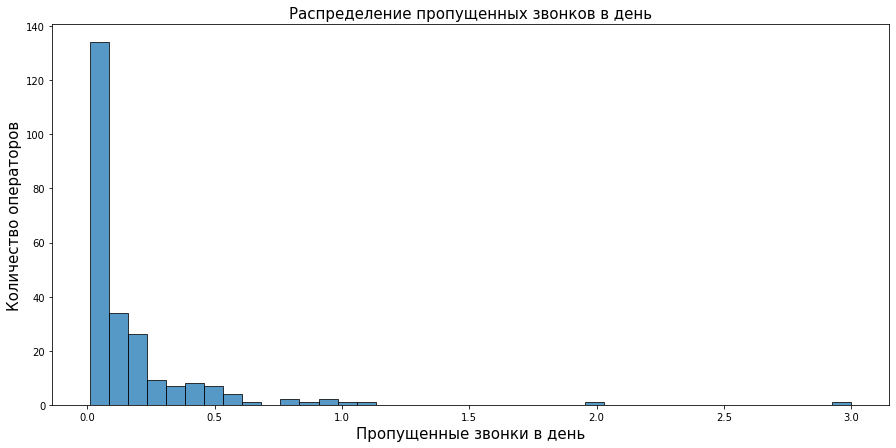

In [1043]:
# построим диаграмму распределения значений пропущенных оператором звонков в день
fig, axes = plt.subplots()
ax = sns.histplot(operator_in_ef[operator_in_ef['missed_day'] > 0]['missed_day'], bins=40)
ax.set_xlabel('Пропущенные звонки в день', fontsize = '15')
ax.set_ylabel('Количество операторов', fontsize = '15')
ax.set_title('Распределение пропущенных звонков в день', fontsize = '15')    
fig.set_figwidth(15)    
fig.set_figheight(7)  

**Вывод** 95% всех операторов допускают 0,3 пропущенных звонка в день, то есть 1 пропущенный звонок в течении 3-4 дней. Более высокий показатель может определять неэффективность оператора.

### Определение среднего времени ожидания ответа оператора на один звонок

В качестве второй возможной метрики оценки эффективности операторов на входящих звонках рассмотрим время ожидания ответа оператора

#### Определить по каждому оператору среднее время ожидания, а также общее среднее время ожидания

In [1044]:
# Сделаем сводную таблицу среднего времени ожидания ответа по операторам
avg_exp = (telecom_dataset.query('operator_id != 0 & direction == "in"')
                         .pivot_table(index='operator_id', values='avg_expectation', aggfunc='mean')
                         .reset_index().sort_values(by='avg_expectation', ascending=False)
                         .reset_index(drop=True)
          )
avg_exp.head()

,operator_id,avg_expectation
0,905842,115.50
1,917680,100.00
2,907174,65.12
3,960296,63.00
4,920930,62.00


In [1045]:
# выведем статистическую информацию по значениям среднего времени ожидания ответа оператора
avg_exp['avg_expectation'].describe(percentiles=[.9, .95, .99])

count   754.00
mean     17.56
std      12.31
min       0.22
50%      14.34
90%      33.58
95%      42.06
99%      57.21
max     115.50
Name: avg_expectation, dtype: float64

**Промежуточный вывод** Среднее время ответа оператора, когда звонок состоялся составляет 18 секунд, 90% операторов в отвечают в течении 34 секунд.

#### Анализ входящих пропущенных звонков, когда абонент не дождался ответа оператора и положил трубку

In [1046]:
telecom_dataset.query('direction == "in" & is_missed_call == True')['avg_expectation'].describe(percentiles=[.9, .95, .99])

count   7,887.00
mean       18.67
std        21.52
min         0.00
50%        14.00
90%        41.00
95%        52.00
99%        92.14
max       465.00
Name: avg_expectation, dtype: float64

**Промежуточный вывод** Среднее время ответа оператора, когда абонент положил трубку и не дождался ответа оператора составляет 19 секунд. А у 90% операторов, когда абонент не дождался ответа время ожидания составляет 41 секунд.

#### Визуализация данных

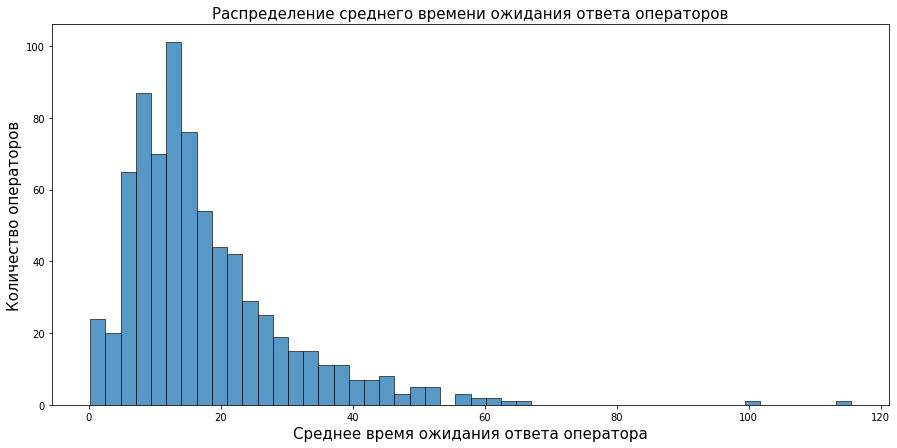

In [1047]:
# построим диаграмму распределения значений среднего времени ожидания ответа операторов
fig, axes = plt.subplots()
ax = sns.histplot(avg_exp['avg_expectation'], bins=50)
ax.set_xlabel('Среднее время ожидания ответа оператора', fontsize = '15')
ax.set_ylabel('Количество операторов', fontsize = '15')
ax.set_title('Распределение среднего времени ожидания ответа операторов', fontsize = '15')    
fig.set_figwidth(15)    
fig.set_figheight(7)  

**Вывод** Проанализировав среднее время ожидания ответа оператора, когда звонок состоялся и когда звонок не состоялся можно прийти к выводу, что с вероятностью выше 90%, если оператор не ответил в течении 41 секунд, то абонент положит трубку. Соответственно мы можем говорить, что операторы, среднее время ожидания ответа которых равно или превышает 41 секунду не могут быть признаны эффективными, поскольку риском их работы будет практически гарантированный пропущенный звонок.

### Получение сведений о нормальном количестве исходящих звонков

Чтобы понять сколько исходящих звонков в день должен совершать оператор, нам необходимо получить сведения о том сколько в среднем тратят операторы на 1 исходящий звонок. Тогда мы сможем расчитать, сколько звонков в день может совершить эффективный оператор с учетом обеда и технических перерывов.

In [1048]:
# Сделаем сводную таблицу по операторам и получим средние показатели по времени ожидания ответа абонента, времени разговора
# и количеством звонков в день
avg_dur = (telecom_dataset.query('user_category == "out" & direction == "out"')
                         .pivot_table(index='operator_id', values=['date', 'calls_count', 'avg_expectation', 'avg_call_duration'], aggfunc={'calls_count': 'sum', 'avg_expectation' : 'mean', 'avg_call_duration':'mean', 'date' : 'nunique'})
                         .reset_index().sort_values(by='avg_call_duration', ascending=False)
                         .reset_index(drop=True)
          )
avg_dur.head(10)

,operator_id,avg_call_duration,avg_expectation,calls_count,date
0,891192,"1,306.00",32.00,1,1
1,918390,484.33,15.21,246,62
2,910926,446.00,12.29,25,7
3,891154,443.98,19.28,528,70
4,909452,424.00,14.00,8,1
5,890232,409.20,14.73,33,15
6,969600,407.50,13.50,19,2
7,910902,393.25,13.12,15,8
8,930524,377.12,16.12,28,8
9,897894,372.00,13.20,19,5


In [1049]:
avg_dur['avg_calls_count'] = avg_dur['calls_count']/avg_dur['date']

In [1050]:
avg_dur.describe(percentiles=[.25, .75, .9, .95, .99])

,operator_id,avg_call_duration,avg_expectation,calls_count,date,avg_calls_count
count,372.00,372.00,372.00,372.00,372.00,372.00
mean,"924,776.70",75.40,15.33,"1,161.15",19.13,42.71
std,"53,972.87",101.61,5.85,"4,715.39",19.13,92.76
min,0.00,0.00,0.00,1.00,1.00,1.00
25%,"905,569.00",29.31,12.04,28.00,5.00,4.00
50%,"930,035.00",49.43,15.90,207.50,14.00,13.57
75%,"947,596.50",84.85,18.94,903.75,25.00,44.86
90%,"958,457.80",139.12,21.37,"2,306.10",46.00,103.37
95%,"965,538.90",248.42,23.13,"3,167.90",62.90,152.09
99%,"972,408.58",429.80,26.89,"15,794.56",78.58,636.48


**Промежуточные выводы** В среднем операторы тратят на 1 исходящий звонок 75 секунд, при этом среднее время ожидания ответа абонента составляет 15 секунд, то есть, учитывая разные ситуации, мы можем предположить, что достаточно логично установить, что на один звонок оператор может тратить 3 минуты. Таким образом, с учетом восьмичасового рабочего дня и наличия обеда и технических перерывов, а также время на звонки, которые не были успешными мы можем говорить о том, что порог в 40 звонков в день является нормальным режимом работы для оператора.

### Получение сведений о неэффективных операторах

Резюмируя разделы выше, я пришел к следующим пороговым значениям по которым мы будем определять неэффективных операторов:

По входящим звонкам:
- значение пропущенных звонков составляет не более 0,3 пропущенных звонка в день
- среднее время ожидания ответа данного оператора составляет больше 40 секунд

По исходящим звонкам:
- оператор совершает менее 40 звонков в день

#### Неэффективные операторы на входящих звонках

In [1051]:
# сделаем список операторов, которые в отчетном периоде пропускали более 0.3 звонков
operator_in_not_ef_1 = list(operator_in_ef[operator_in_ef['missed_day'] > 0.3]['operator_id'])
len(operator_in_not_ef_1)

37

In [1052]:
# сделаем список операторов, время ожидания ответа которых в отчетном периоде превышал 40 секунд
operator_in_not_ef_2 = list(avg_exp[avg_exp['avg_expectation'] > 40]['operator_id'])
len(operator_in_not_ef_2)

40

In [1053]:
# объединим данные списки и удалим дубликаты, если они есть
operator_in_not_ef = list(set(operator_in_not_ef_1 + operator_in_not_ef_2))
len(operator_in_not_ef)

77

**Вывод** я получил список из 77 операторов, специализирующихся на входящих звонках, которые не могут быть отнесены к эффективным, в соответствии с предложенными мной метрикми

#### Неэффективные операторы на исходящих звонках

In [1054]:
# сделаем список операторов, которые 
operator_out_not_ef = list(out_done.query('avg_calls_day < 40')['operator_id'])
len(operator_out_not_ef)


261

**Вывод** в соответствии с проведенным исследованием 261 оператора на исходящих звонках нельзя отнести к категории эффективных

#### Объединим списки неэффективных операторов

In [1055]:
operator_not_ef = (operator_in_not_ef + operator_out_not_ef)
len(operator_not_ef)

338

#### Сделаем сводную таблицу по колл-центрам с количеством операторов и количеством неэффективных операторов

In [1056]:
# сделаем таблицу с количеством операторов в каждом колл-центре, которые работали в исследуемом периоде
user_count_operator = (telecom_dataset.pivot_table(index='user_id', values='operator_id', aggfunc='nunique')
                                      .reset_index()
                                      .sort_values(by='operator_id', ascending=False)
                                      .reset_index(drop=True)                                      
                      )
user_count_operator.head()

,user_id,operator_id
0,168187,51
1,167626,49
2,167497,31
3,168252,29
4,168062,28


In [1057]:
# сделаем таблицу с количеством неэффективных операторов в каждом колл-центре, которые работали в исследуемом периоде
user_count_operator_not_ef = (telecom_dataset.query('operator_id in @operator_not_ef')
                                             .pivot_table(index='user_id', values='operator_id', aggfunc='nunique')
                                             .reset_index()
                                             .sort_values(by='operator_id', ascending=False)
                                             .reset_index(drop=True)
                             )
user_count_operator_not_ef.head()

,user_id,operator_id
0,167497,30
1,166658,16
2,166680,15
3,166520,15
4,168062,13


In [1058]:
# соединим две таблицы и получим общее число колл-центров
user_count_operator = user_count_operator.merge(user_count_operator_not_ef, how = 'left', on='user_id')
user_count_operator.columns = ['user_id', 'operator_all', 'operator_not_ef']
user_count_operator['operator_ef'] = user_count_operator['operator_all'] - user_count_operator['operator_not_ef']
user_count_operator['user_id'].count()

307

In [1059]:
# получим число колл-центров, в которых работали неэффективные операторы
user_count_operator = user_count_operator.sort_values(by='operator_not_ef', ascending=False).reset_index(drop=True)
user_count_operator.query('operator_not_ef > 0')['user_id'].count()

97

#### Визуализируем данные

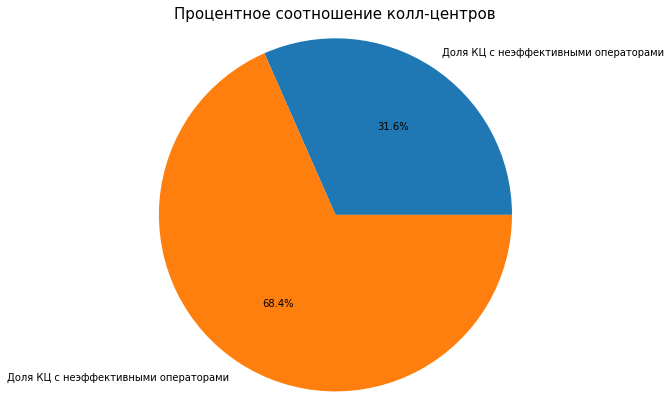

In [1060]:

x=user_count_operator.query('operator_not_ef > 0')['user_id'].count()
y=(user_count_operator['user_id'].count() - user_count_operator.query('operator_not_ef > 0')['user_id'].count())
# Круговая диаграмма
vals = [x, y]
labels = ["Доля КЦ с неэффективными операторами", "Доля КЦ с неэффективными операторами"]
fig, ax = plt.subplots()
ax.pie(vals, labels=labels, autopct='%1.1f%%')
ax.axis("equal")
fig.set_size_inches(7,7)
ax.set_title('Процентное соотношение колл-центров', fontsize = '15')
plt.show()
plt.show()

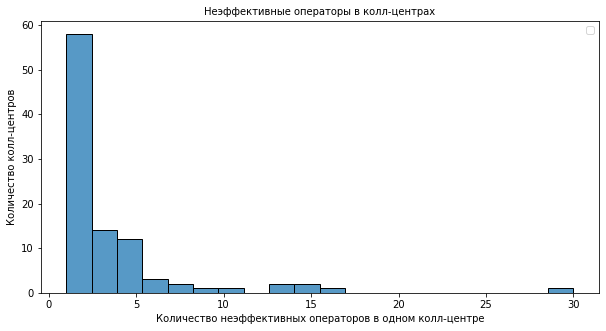

In [1066]:
# Получим распредение числа неэффективных операторов в колл-центре
fig, axes = plt.subplots()
ax = sns.histplot(user_count_operator_not_ef.query('operator_id > 0'), bins=20)

ax.set_xlabel('Количество неэффективных операторов в одном колл-центре', fontsize = '10')
ax.set_ylabel('Количество колл-центров', fontsize = '10')
ax.set_title('Неэффективные операторы в колл-центрах', fontsize = '10')    
fig.set_figwidth(10)   
plt.legend('')
fig.set_figheight(5)  

### **Выводы**:
- по разработанным метрикам эффективности операторов было выявлено 338 операторов, работа которых в исследуемом периоде не может быть признана эффективной, причем основная часть этих операторов, специализируется на исходящих звонках
- Доля колл-центров в которых были выявлены неэффективные операторы составляет 32%
- наиболее часто встречается, что в колл-центре 1 неэффективный оператор, но также встречаются колл-центры, где количество неэффективных операторов составляет больше 10 человек и даже 29 человек

## Проверка статистических гипотез

### Гипотеза 1

- Нулевая гипотеза - Разница между средними долями принятых звонков, относительно общего количества звонков операторов гибридных колл-центров и колл-центров, специализирующихся на входящих звонках статистически значима
- Альтернативная гипотеза - Разница между средними долями принятых звонков, относительно общего количества звонков операторов гибридных колл-центров и колл-центров, специализирующихся на входящих звонках статистически незначительна.

In [1062]:
# добавим к данным о доле принятых входящих звонков сведения о категории оператора
operator_in_ef = operator_in_ef.merge(operator_in_out[['operator_id', 'operator_category']], how = 'left', on='operator_id')
operator_in_ef.head()

,operator_id,accept,missed,calls_all,share_accept,date,calls_day,missed_day,operator_category
0,913938,4752,14,4766,1.00,65,73.32,0.22,in
1,952948,3534,8,3542,1.00,26,136.23,0.31,in
2,893804,2423,10,2433,1.00,93,26.16,0.11,hybrid
3,913942,2415,52,2467,0.98,57,43.28,0.91,in
4,921318,2317,6,2323,1.00,45,51.62,0.13,hybrid


In [1063]:
# проведем t-test

alpha = .05 # критический уровень статистической значимости

results = st.ttest_ind(
    operator_in_ef.query('operator_category == "in"')['share_accept'], 
    operator_in_ef.query('operator_category == "hybrid"')['share_accept'])

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 0.43075206949330935
Не получилось отвергнуть нулевую гипотезу


**Вывод** Разница между средними долями принятых звонков операторами специализирующимися на входящих звонках в колл-центрах, специализирующихся на входящих звонках и колл-центрах гибридного типа статистически незначительна.

### Гипотеза 2

- Нулевая гипотеза - Разница между средними долями успешных исходящих звонков, относительно общего количества звонков операторов гибридных колл-центров и колл-центров, специализирующихся на исходящих звонках статистически значима
- Альтернативная гипотеза - Разница между средними долями успешных исходящих звонков, относительно общего количества звонков операторов гибридных колл-центров и колл-центров, специализирующихся на исходящих звонках статистически незначительна

In [1064]:
# добавим к данным о доле успешных звонков сведения о катгеории оператора
out_done = out_done.merge(operator_in_out[['operator_id', 'operator_category']], how = 'left', on='operator_id')
out_done.head()

,operator_id,calls_all,calls_lucky,share_lucky,date,avg_calls_day,operator_category_x,operator_category_y,operator_category
0,885890,58977,35196,0.60,80,737.21,out,out,out
1,885876,58434,35119,0.60,97,602.41,out,out,out
2,929428,23754,4636,0.20,33,719.82,out,out,out
3,925922,19603,10355,0.53,24,816.79,out,out,out
4,908640,14234,6072,0.43,19,749.16,out,out,out


In [1065]:
# проведем t-test

alpha = .05 # критический уровень статистической значимости

results = st.ttest_ind(
    out_done.query('operator_category == "out"')['share_lucky'], 
    out_done.query('operator_category == "hybrid"')['share_lucky'])

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 0.5834143061975764
Не получилось отвергнуть нулевую гипотезу


**Вывод** Разница между средними долями успешных звонков операторами специализирующимися на исходящих звонках в колл-центрах, специализирующихся на входящих звонках и колл-центрах гибридного типа статистически незначительна.

## Общие выводы и рекомендации

В рамках проведенного исследования можно сделать следующие выводы:
- Доля колл-центров по специфике составляет 44% "входящие", 32% "гибридные", 24% "исходящие"
- Доля операторов по специфике составляет 50% "исходящие", 29% "входящие", 21% "гибридные"
- Были выработаны следующие метрики эффективности операторов:
       - значение пропущенных звонков не должно превышать 0.3 в день
       - среднее время ожидания ответа не должно превышать 40 секунд
       - ежедневно оператор должен делать не менее 40 исходящих вызовов
- Анализ операторов, специализирующихся на исходящих звонках показал, что у нас, что то не так с организацией этого направления бизнеса
- Доля колл-центров с неэффективными операторами составляет 32%
- По некоторым колл-центрам число неэффективных операторов составляет более 30 человек.
- Введение наглядных механизмов визуализации и выявления неэффективных операторов позволит улучшить показатели бизнеса.